# Hyper-parameters in Action!

## Part 1 - Activation Functions

### This notebook generates the animations I used in my [blog post](https://towardsdatascience.com/hyper-parameters-in-action-a524bf5bf1c).

In [ ]:
# To run this notebook on Google Colab, you need to run these two commands first
# to install FFMPEG (to generate animations - it may take a while to install!)
# and the actual DeepReplay package

#!apt-get install ffmpeg
#!pip install deepreplay

In [ ]:
from keras.layers import Dense
from keras.models import Sequential

from deepreplay.datasets.parabola import load_data
from deepreplay.callbacks import ReplayData
from deepreplay.replay import Replay
from deepreplay.plot import compose_animations, compose_plots

import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Dataset

### Fetch the dataset from the Data Folder at [UCI Machine Learning Repository: Spambase Data Set](https://archive.ics.uci.edu/ml/datasets/spambase)

In [ ]:
# Download it using wget (Linux) or manually download it and place on the same folder as this notebook
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data

--2018-04-29 21:18:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702942 (686K) [text/plain]
Saving to: ‘spambase.data’

100%[======================================>] 702,942      590KB/s   in 1.2s   

2018-04-29 21:18:14 (590 KB/s) - ‘spambase.data’ saved [702942/702942]



### Loads data and creates ReplayData callback

In [ ]:
group_name = 'spam'

# Loads the CSV data
df = pd.read_csv('SpamDataset.csv')

print(df.head())

# The first 57 columns are features
# The last column has the correct labels (targets)
X, y = df.iloc[:, :57].values, df.iloc[:, 57].values

# Scale the features, as the original values have wide ranges
X = StandardScaler().fit_transform(X)

replaydata = ReplayData(X, y, filename='spambase_dataset.h5', group_name=group_name)

### Builds Keras model

In [ ]:
he_initializer = keras.initializers.initializers_v2.HeNormal(seed=42)
normal_initializer = keras.initializers.initializers_v2.RandomNormal(seed=42)

model = Sequential()
# Hidden layer with 10 units, taking the 57 features as inputs
model.add(Dense(input_dim=57,
                units=10,
                kernel_initializer=he_initializer,
                activation='tanh'))

# Added layer to allow plotting the feature space
# It has 2 units and uses a LINEAR activation, so the network will also learn the
# mapping from 10-dimensions to 2-dimensions
model.add(Dense(units=2,
                kernel_initializer=normal_initializer,
                activation='linear',
                name='hidden'))

# Typical output layer for binary classification
model.add(Dense(units=1,
                kernel_initializer=normal_initializer,
                activation='sigmoid',
                name='output'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                580       
_________________________________________________________________
hidden (Dense)               (None, 2)                 22        
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 605
Trainable params: 605
Non-trainable params: 0
_________________________________________________________________
None


### Trains the model using ReplayData as a callback to store the information

In [ ]:
model.fit(X, y, epochs=100, batch_size=16, callbacks=[replaydata])

Epoch 1/100
4601/4601 [==============================] - 0s 46us/step - loss: 0.5176 - acc: 0.7963
Epoch 2/100
4601/4601 [==============================] - 0s 41us/step - loss: 0.2326 - acc: 0.9211
Epoch 3/100
4601/4601 [==============================] - 0s 42us/step - loss: 0.2022 - acc: 0.9298
Epoch 4/100
4601/4601 [==============================] - 0s 41us/step - loss: 0.1890 - acc: 0.9307
Epoch 5/100
4601/4601 [==============================] - 0s 42us/step - loss: 0.1806 - acc: 0.9331
Epoch 6/100
4601/4601 [==============================] - 0s 44us/step - loss: 0.1748 - acc: 0.9357
Epoch 7/100
4601/4601 [==============================] - 0s 41us/step - loss: 0.1704 - acc: 0.9374
Epoch 8/100
4601/4601 [==============================] - 0s 42us/step - loss: 0.1668 - acc: 0.9396
Epoch 9/100
4601/4601 [==============================] - 0s 41us/step - loss: 0.1636 - acc: 0.9376
Epoch 10/100
4601/4601 [==============================] - 0s 41us/step - loss: 0.1607 - acc: 0.9400
Epoch 11/

### Builds figure to attach the plots to

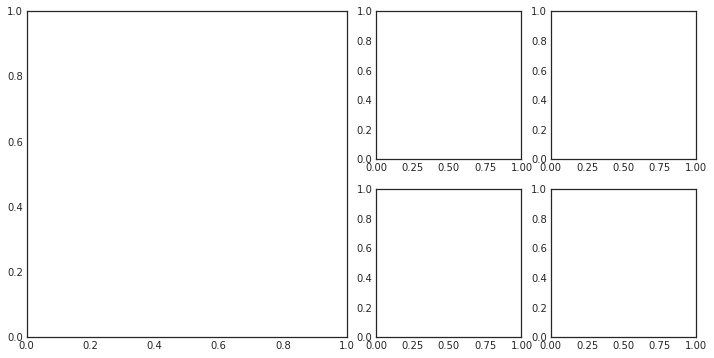

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax_fs = plt.subplot2grid((2, 4), (0, 0), colspan=2, rowspan=2)
ax_ph_neg = plt.subplot2grid((2, 4), (0, 2))
ax_ph_pos = plt.subplot2grid((2, 4), (1, 2))
ax_lm = plt.subplot2grid((2, 4), (0, 3))
ax_lh = plt.subplot2grid((2, 4), (1, 3))

### Loads data into Replay and builds the plots

In [ ]:
replay = Replay(replay_filename='spambase_dataset.h5', group_name=group_name)

fs = replay.build_feature_space(ax_fs, layer_name='hidden', scale_fixed=False)
ph = replay.build_probability_histogram(ax_ph_neg, ax_ph_pos)
lh = replay.build_loss_histogram(ax_lh)
lm = replay.build_loss_and_metric(ax_lm, 'acc')

### Plotting the figure for 80th epoch

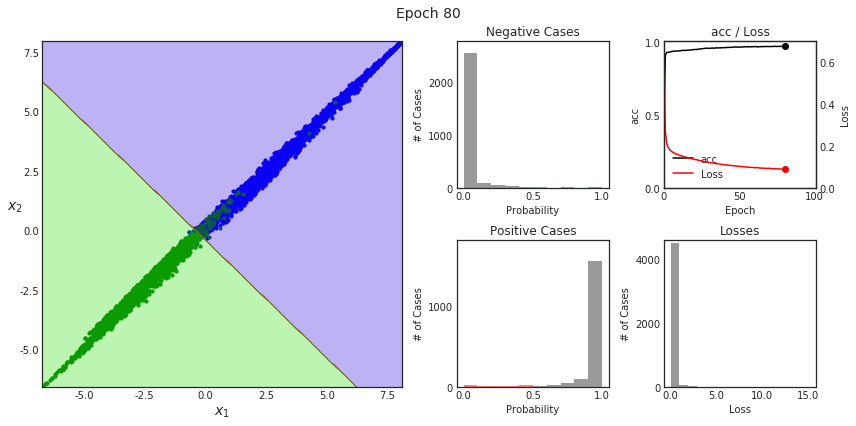

In [ ]:
sample_figure = compose_plots([fs, ph, lm, lh], 80)
sample_figure

### Animating the plot

In [ ]:
sample_anim = compose_animations([fs, ph, lm, lh])
HTML(sample_anim.to_html5_video())